In [127]:
#data
import yfinance as yf
import datetime
import numpy as np

def get_historical_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    return data['Close']

# Define the tickers for the S&P 500 index and the 20 stocks
tickers = ['^GSPC', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'V', 'JNJ', 'UNH', 'BAC', 'TSLA', 'NVDA', 'WMT', 'PG', 'VZ', 'MA', 'HD', 'DIS', 'CMCSA']

# Calculate the start and end dates for the last six months
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=400)

# Retrieve the historical prices for the tickers
prices = get_historical_prices(tickers, start_date, end_date)

# Print the retrieved prices
print(prices,prices.shape,prices.pct_change())


                  AAPL        AMZN        BAC      CMCSA        DIS   
Date                                                                  
2022-10-12  138.339996  112.900002  29.860001  28.690001  93.410004  \
2022-10-13  142.990005  112.529999  31.690001  30.230000  96.639999   
2022-10-14  138.380005  106.900002  31.700001  30.049999  94.449997   
2022-10-17  142.410004  113.790001  33.619999  30.820000  97.330002   
2022-10-18  143.750000  116.360001  34.880001  30.750000  98.480003   
...                ...         ...        ...        ...        ...   
2023-11-09  182.410004  140.600006  27.530001  40.880001  90.339996   
2023-11-10  186.399994  143.559998  27.680000  41.910000  88.269997   
2023-11-13  184.800003  142.589996  27.700001  41.490002  89.440002   
2023-11-14  187.440002  145.800003  29.219999  41.869999  91.070000   
2023-11-15  188.009995  143.199997  29.620001  42.529999  93.930000   

                 GOOGL          HD         JNJ         JPM          MA   
Da

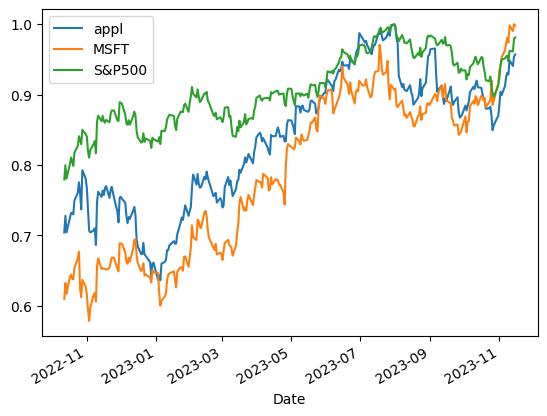

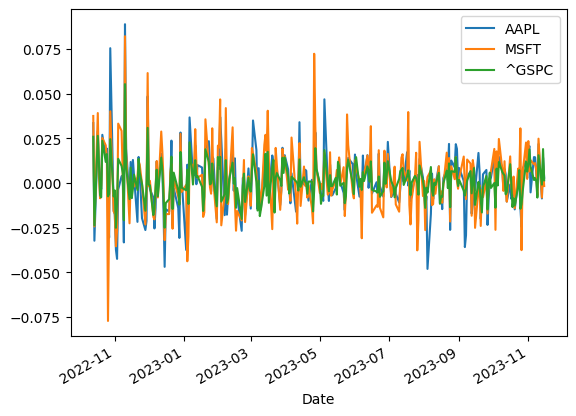

In [113]:
#data representation
import matplotlib.pyplot as plt
pct_prices = prices.pct_change()
for column in prices.columns:
    normal_prices[column] = prices[column]/max(prices[column])

# print(prices/max(prices['^GSPC']))
normal_prices['AAPL'].plot(label = 'appl')
normal_prices['MSFT'].plot(label = 'MSFT')
normal_prices['^GSPC'].plot(label = 'S&P500')
plt.legend()
plt.show() 
pct_prices.plot()
plt.show()

In [255]:
import pyomo.environ as pyo

# create a model
model = pyo.ConcreteModel()


#model size parameters
T = prices.shape[0]
N = prices.shape[1]-1
model.T = pyo.Param(initialize = prices.shape[0]) #time duration
model.N = pyo.Param(initialize = prices.shape[1]-1) #universe of assets #all dataset - index itself

#indices
model.i = pyo.Set(initialize = np.arange(model.N))#index for stocks
model.t = pyo.Set(initialize = np.arange(model.T))#index for time periods starts from 0
model.t0 = pyo.Set(initialize = np.arange(1,model.T))

#model parameters
V =  np.array(prices.drop(['^GSPC'] ,axis = 1)).T
model.V = pyo.Param(model.i,model.t,initialize = lambda m, i, t: V[i,t])
model.V0 = pyo.Param(model.i,model.t0,initialize = lambda m, i, t0: V[i,t0])

R = np.array([np.log(np.array(prices['^GSPC'][t])/np.array
(prices['^GSPC'][t-1])) if t!=0 else 0 for t in model.t ]) #return of index in period t
model.R = pyo.Param(model.t,initialize = lambda m,t:R[t])

I = np.array(prices['^GSPC']) #value of index in period t
model.I = pyo.Param(model.t,initialize = lambda m,t:I[t])

model.epsilon = pyo.Param(model.i,initialize = 0.01)
model.delta = pyo.Param(model.i,initialize = 0.99)

model.K = pyo.Param(initialize = 10) #cardinality
model.gamma = pyo.Param(initialize = 0.2) #portfolio of C that can be consumed for transaction costs
model.trans = pyo.Param(initialize = 0.01) #amount of transaction if consumed to move from V[i,T]X[i] to V[i,T]x[i] or vice verca
model.C_cash = pyo.Param(initialize = 1000) #$
X = np.random.randint(1,size = (N,))
model.X = pyo.Param(model.i,initialize = lambda m,i:X[i]) #current tracking portfolio


print(f'we have {model.N+1-1} assets and {model.T+1} periods')
print(f'our random initial portfolio: {[model.X[i] for i in range(N)]}')

# declare decision variables
# model.X = pyo.Var(model.i,domain=pyo.PositiveIntegers,bounds = (0,200)) #unit of asset i in current tracking portfolio
model.x = pyo.Var(model.i,domain=pyo.NonNegativeReals,bounds = (0,1000)) #unit of asset i in new tracking portfolio
model.z = pyo.Var(model.i,domain = pyo.Binary) #1 if asset selected

#auxilary parameters and variables
model.M = pyo.Param(initialize = 5000000)
model.y = pyo.Var(model.t0,domain = pyo.Binary) #1 for linearize maximum in objective function
model.xX = pyo.Var(model.i,domain = pyo.Binary) #absolute of x-X 
devision_error = 1e-06
#parameters with expressions
# def r_expression_rule(model,t):
#   return pyo.log(sum(model.V[i,t] * model.x[i] for i in model.i)/ sum(model.V[i,t-1] * model.x[i] for i in model.i))


# model.r = pyo.Expression(model.t0, rule=r_expression_rule)




#C_cash,C_trans

#objective
def Obj(model):
  # return 1/T * sum(model.y[t]*abs(model.R[t]-((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  # (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1  ) )  for t in range(1,len(model.t)))
  
  
  return 1/T * sum( abs(model.R[t]-((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
   (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1  ) )    for t in range(1,len(model.t)) )





#constraints
def Co1(model): #cardinality #3
  return sum(model.z[i] for i in model.i) == model.K 
def Co2(model,i): #cardinality
  return ((model.V[i,T-1] * model.x[i]) / (sum(model.V[i,T-1]*model.X[i]  for i in model.i) + model.C_cash)  ) <= model.z[i] * model.delta[i] #4  
def Co3(model,i): #cardinality
  return ((model.V[i,T-1] * model.x[i]) / (sum(model.V[i,T-1]*model.X[i]  for i in model.i) + model.C_cash)  ) >= model.z[i] * model.epsilon[i] #4
def Co4(model): #5 maximum amount that is allowed to use for transaction
  return sum(abs(model.x[i] - model.X[i])  * model.trans * model.V[i,T-1] for i in model.i) <= model.gamma * (sum(model.V[i,T-1]*model.X[i]  for i in model.i)+model.C_cash) #5
  # return sum(((model.x[i] - model.X[i])*model.xX[i]+(model.X[i] - model.x[i])*(1-model.xX[i]))  * model.trans * model.V[i,T-1] for i in model.i) <= model.gamma * (sum(model.V[i,T-1]*model.X[i]  for i in model.i)+model.C_cash) #5
def Co5(model): #6
  return sum(model.V[i,T-1] * model.x[i] for i in model.i) == (sum(model.V[i,T-1]*model.X[i]  for i in model.i) + model.C_cash) - sum(abs(model.x[i] - model.X[i])  * model.trans * model.V[i,T-1] for i in model.i)

# def Co6(model,i):#to linearize abs in constraint 5 and 6
#   return (model.x[i] - model.X[i]) * model.xX[i] + (model.X[i] - model.x[i]) * (1-model.xX[i])  >= 0  
  
def Co7(model,t): #does not penalize objective for excess returns
  return (((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1  ) - model.R[t])<=model.M*(1-model.y[t]) 
def Co8(model,t):
  return ( model.R[t]-((sum(model.V[i,t] * model.x[i] for i in model.i)/ 
  (sum(model.V[i,t-1] * model.x[i] for i in model.i)+devision_error))-1  ) )<=model.M*model.y[t]

  
  
  
  

# def Co3(model):
#   return 
#constructing model
model.obj = pyo.Objective(rule = Obj,sense = pyo.minimize)
model.Co1 = pyo.Constraint(rule = Co1)
model.Co2 = pyo.Constraint(model.i,rule = Co2)
model.Co3 = pyo.Constraint(model.i,rule = Co3)
model.Co4 = pyo.Constraint(rule = Co4)
model.Co5 = pyo.Constraint(rule = Co5)
# model.Co6 = pyo.Constraint(model.i,rule = Co6)
# model.Co7 = pyo.Constraint(model.t0,rule = Co7)
# model.Co8 = pyo.Constraint(model.t0,rule = Co8)

we have 18 assets and 277 periods
our random initial portfolio: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from pyomo.core.expr.visitor import identify_variables
from pyomo.core.base.var import IndexedVar
for constraint in model.component_data_objects(pyo.Constraint, active=True):
    print(f"{constraint}: {constraint.body}")

    variables = identify_variables(constraint.body)
    for var in variables:
        if isinstance(var, IndexedVar):
            var_name = f"{var.name}[{','.join(map(str, var.index_set()))}]"
        else:
            var_name = var.name
        print(f"\t{var_name}: {var.value}")

    print()
objective = model.component('obj')
print(f"Objective: {objective.expr}")

In [256]:
# import logging
# logging.getLogger('pyomo.core').setLevel(logging.DEBUG)
#solvers
# solver = pyo.SolverFactory('glpk',executable = 'C:\glpk-4.65\w64\glpsol')
#ALPHAECP
solver = pyo.SolverFactory('gams')
# solver.options['optcr'] = 0.01  # Set the optimality criterion
# solver.options['reslim'] = 60  # Set the time limit in seconds
results = solver.solve(model)
                            # ,solver='ANTIGONE', keepfiles=True, tee=True)

# pyo.SolverFactory('mindtpy').solve(model,
#                                    strategy='GOA',
#                                    mip_solver='cplex',
#                                    nlp_solver='scip')
model.display()


Model unknown

  Variables:
    x : Size=18, Index=i
        Key : Lower : Value             : Upper : Fixed : Stale : Domain
          0 :     0 :               0.0 :  1000 : False : False : NonNegativeReals
          1 :     0 :               0.0 :  1000 : False : False : NonNegativeReals
          2 :     0 : 3.359830933594185 :  1000 : False : False : NonNegativeReals
          3 :     0 :               0.0 :  1000 : False : False : NonNegativeReals
          4 :     0 :               0.0 :  1000 : False : False : NonNegativeReals
          5 :     0 : 0.741809256214507 :  1000 : False : False : NonNegativeReals
          6 :     0 :               0.0 :  1000 : False : False : NonNegativeReals
          7 :     0 : 0.280443528404108 :  1000 : False : False : NonNegativeReals
          8 :     0 : 0.410797579549277 :  1000 : False : False : NonNegativeReals
          9 :     0 : 0.357835663432255 :  1000 : False : False : NonNegativeReals
         10 :     0 : 0.450784156564958 :  1

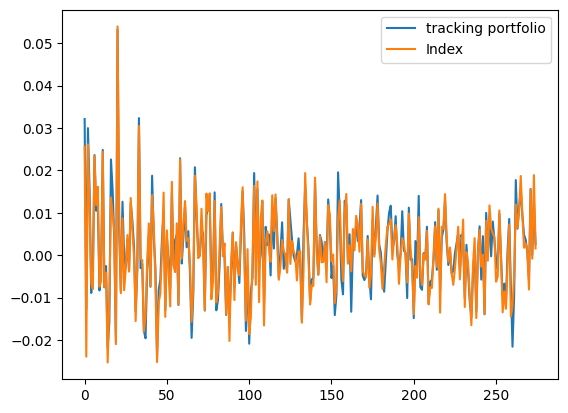

In [257]:
#plotting model.x portfolio from t=1,...,T
r_tracking = [(sum(model.V[i,t]*model.x[i].value for i in model.i))/(sum(model.V[i,t-1]*model.x[i].value for i in model.i))-1  for t in model.t0 ]
Index = [model.R[t] for t in model.t0]
plt.plot(r_tracking,label = 'tracking portfolio')
plt.plot(Index , label = 'Index')
plt.legend()
plt.show()


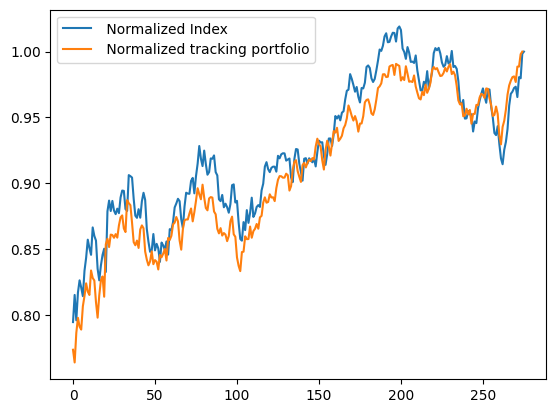

In [258]:
I = I/I[-1]
y = [100 * (1 + sum(r_tracking[:i])) for i in range(1, len(r_tracking)+1)]
y = y/y[-1]
plt.plot(I,label=' Normalized Index')
plt.plot(y,label=' Normalized tracking portfolio')
plt.legend()
plt.show()